## Project Template

In [2]:
#Demographic features: Age at Diagnosis, Year of Diagnosis, Sex, Race, Ethnicity
#Clinical features: primary cancer site, tumor grade, summary stage
#Socioeconomic features:Marital Status, Transportation, Appalachia

import pandas as pd
import numpy as np


##part 1:read dataset
df= pd.read_csv('SEER.csv')
df.head()


,Age with single ages and 100+,Sex,Year of diagnosis,Race,Ethnicity,Marital status at diagnosis,Primary Site,Histologic Type ICD-O-3,Grade,Summary Stage (2004+),Surgery of Primary Site,Radiation,Chemotherapy,COD recode,Survival recode,Appalachia,SEER registry state,Unnamed: 17
0,66,0,2013,1,0,1,18.0,8263,2,1,1,0,0,2,1,0,Georgia,NaN
1,70,0,2010,0,0,1,18.7,8140,2,1,0,1,1,0,0,0,Georgia,NaN
2,48,0,2001,0,0,1,18.7,8140,2,99,1,0,0,2,1,0,Georgia,NaN
3,54,0,2006,1,0,1,18.2,8490,3,3,1,0,0,1,0,0,Georgia,NaN
4,88,1,2009,0,0,0,18.0,8140,2,3,1,0,0,1,0,0,Kentucky,NaN


In [6]:
##part 2: include features
from sklearn.preprocessing import LabelEncoder
dfnew = df[['Age with single ages and 100+', 'Year of diagnosis', 'Sex','Race','Ethnicity','Primary Site','Grade ','Summary Stage (2004+)','Marital status at diagnosis','Appalachia','Survival recode'
]]
dfnew
dfnew = dfnew.rename(columns={
    'Survival recode': 'Survival_Recode'
})

dfnew = dfnew[dfnew['Survival_Recode'] != 99]
##cleaning non-ordinal values and cleaning survival recode na
find_non_numeric = dfnew.select_dtypes(include=['object']).columns
for col in find_non_numeric:
    dfnew[col] = LabelEncoder().fit_transform(dfnew[col].astype(str))



## AUROC Plots: FPR, TPR, Threshold

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve
def generate_auc_roc_curve(model, X_test, y_true):
    y_pred = model.predict_proba(X_test)[:,1]
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    auc_t = round(auc,3)
    return fpr, tpr, threshold, auc_t

## Bootstrapping by resampling method 

In [8]:
from sklearn.utils import resample
from sklearn import metrics
from sklearn.metrics import confusion_matrix

rng_seed = 42  # control reproducibility

#build confusion matrix with boostrapping by resampling
def confmat(clf, X_test, y_test, n_iter):
    tnr = np.zeros(n_iter)  #true neg
    tpr = np.zeros(n_iter)  #true pos
    ppv = np.zeros(n_iter)  #pos pred
    npv = np.zeros(n_iter) #neg pred
    for i in range(n_iter):
        # bootstrap by sampling with replacement on the prediction indices
        X_test_resample, y_test_resample = resample(X_test, y_test)
        clf.fit(X_test_resample, y_test_resample)
        y_pred_resample = clf.predict(X_test_resample)
        tn, fp, fn, tp = metrics.confusion_matrix(y_test_resample, y_pred_resample, labels=[0,1]).ravel()
        #print ("metrics: {}, {}, {}, {} " .format(tn, fp, fn, tp))
        #sensitivity
        sensitivity = tp/(tp+fn)
        tpr[i]=sensitivity
        #print ("tpr: {}, {}" .format(i, sensitivity))
    
        #specificity
        specificity = tn/(tn+fp)
        tnr[i]=specificity
        
        #precision
        precision = tp/(tp+fp)
        ppv[i]=precision
        
        #Negative predictive value
        negative_pv = tn/(tn+fn)
        npv[i]=negative_pv
        #print (npv) 
    return tnr, tpr, ppv, npv

## Confidence Intervals 

In [9]:
#cacluate metrics and confidence intervals
def confmat_metrics (confusion_metric):
    sorted_metric = np.array(confusion_metric)   
    sorted_metric.sort()

    #confidence interval 95: [0.025 - 0.975]
    ci_lower = sorted_metric[int(0.025 * len(sorted_metric))]
    ci_upper = sorted_metric[int(0.975 * len(sorted_metric))]
    #print("Confidence interval: [{} - {}]".format(round(ci_lower,3), round(ci_upper,3)))
    return ci_lower, ci_upper 

### Divide Data into Appalachia and Non-Appalachia records

In [10]:
data_A = dfnew[dfnew['Appalachia'] == 1]
data_NA = dfnew[dfnew['Appalachia'] == 0]

### Standardize and Scale the feature data: Appalachia

In [11]:
#Standardize and Scale the Feature Data:Appalachia
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

ss_a=StandardScaler()
ss_a.fit_transform(data_A.drop(['Survival_Recode'], axis=1))
scaled_data=ss_a.transform(data_A.drop(['Survival_Recode'], axis=1))
scaled_df=pd.DataFrame(scaled_data, columns=data_A.columns[:-1])

In [12]:
#setup X and y
#X_A = scaled_df.drop(['Survival_Recode'], axis=1)

X_A = scaled_df
y_A=data_A['Survival_Recode']


### Standardize and scale the feature data: non-Appalachia

In [13]:
from sklearn.preprocessing import StandardScaler
ss_na=StandardScaler()
ss_na.fit_transform(data_NA.drop(['Survival_Recode'], axis=1))
scaled_data_NA = ss_a.transform(data_NA.drop(['Survival_Recode'], axis=1))
scaled_df_NA= pd.DataFrame(scaled_data_NA, columns=data_NA.columns[:-1])

In [14]:
#setup X and y
#X_NA = scaled_df_NA.drop(['Survival_Recode'], axis=1)
X_NA = scaled_data_NA
y_NA=data_NA['Survival_Recode']

### Appalachia: Split Data into Train, Test, and Validate: 70-20-10

In [15]:
from sklearn.model_selection import train_test_split
X_trainA, X_otherA, y_trainA, y_otherA = train_test_split(X_A, y_A, test_size=0.30, random_state=42)
##splitting the 30 percent
X_testA, X_valA, y_testA, y_valA = train_test_split(X_otherA, y_otherA, test_size=0.33, random_state=42)

In [16]:
sum(y_trainA)/len(y_trainA)

0.3871650663986485

In [ ]:
sum(y_testA)/len(y_testA)

0.38427167113494193

### Build Model: Applachia

#### model:
    ### Model1: Logistic Regression: Pick a model and justify: Options: Newton-CG, liblinear, lbfgs
    ### Model2: XGboost: Try default and hyperparametrized models  

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

##logistic regression 
solvers = ['newton-cg', 'liblinear', 'lbfgs']
res= {}
for solver in solvers: 
    model = LogisticRegression(solver=solver, random_state=5)
    model.fit(X_trainA, y_trainA)
    y_valA_pred = model.predict(X_valA)
    print(f"solver: {solver}, validation accuracy: {accuracy_score(y_valA, y_valA_pred)}")
    res[f"{solver}"] = accuracy_score(y_valA, y_valA_pred)



solver: newton-cg, validation accuracy: 0.6713032960387058
solver: liblinear, validation accuracy: 0.6714544904747505
solver: lbfgs, validation accuracy: 0.6714544904747505


In [18]:
##xgboost - default 
import xgboost as xgb
from xgboost import XGBClassifier
xgbc = XGBClassifier(random_state=42)
xgbc.fit(X_trainA, y_trainA, verbose=True)
y_valA_pred_xgb = xgbc.predict(X_valA)

accuracy_score(y_valA, y_valA_pred_xgb)

0.7834895675839129

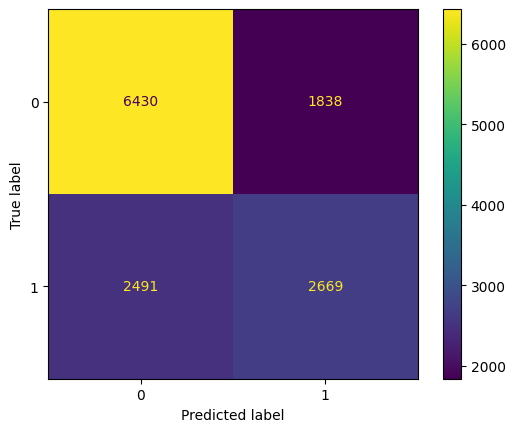

In [19]:
##
#Appalachia: confusion matrix
##for newton-cg

from sklearn import metrics
import matplotlib.pyplot as plt
modelncg = LogisticRegression(solver='newton-cg', random_state=42)
modelncg.fit(X_trainA, y_trainA)
y_testA_pred = modelncg.predict(X_testA)
cm_a = metrics.confusion_matrix(y_testA, y_testA_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_a)
cm_display.plot()
plt.show()

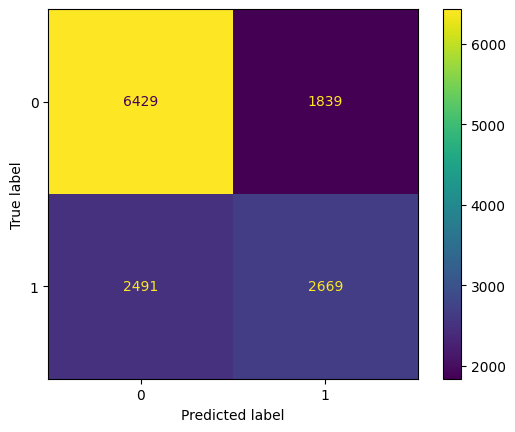

In [20]:
##
#Appalachia: confusion matrix
##for liblinear

from sklearn import metrics
import matplotlib.pyplot as plt
modellib = LogisticRegression(solver='liblinear', random_state=42)
modellib.fit(X_trainA, y_trainA)
y_testA_pred = modellib.predict(X_testA)
cm_a = metrics.confusion_matrix(y_testA, y_testA_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_a)
cm_display.plot()
plt.show()

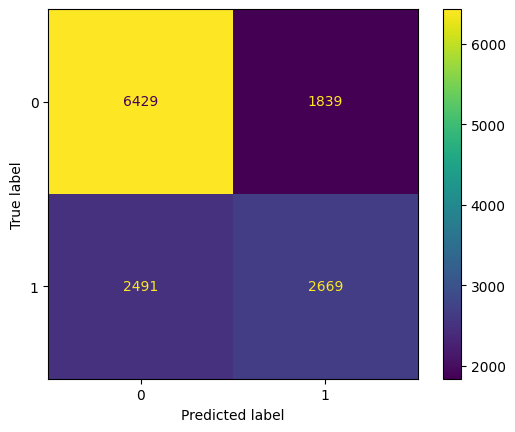

In [21]:
#Appalachia: confusion matrix
##for lbfgs
from sklearn import metrics
import matplotlib.pyplot as plt
model3 = LogisticRegression(solver='lbfgs', random_state=42)
model3.fit(X_trainA, y_trainA)
y_testA_pred = model3.predict(X_testA)
cm_a = metrics.confusion_matrix(y_testA, y_testA_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_a)
cm_display.plot()
plt.show()

### Appalachia: Hyperparametrization 

In [22]:
# Hyper-parameter grid for XGBoost
params = {
        'min_child_weight': [1, 3, 5, 7, 9, 10],
        'gamma': [0, 0.3, 0.5, 1, 1.2, 1.5, 2, 3, 4, 5],
        'subsample': [0.4, 0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'colsample_bylevel': [0.6, 0.8, 1.0],
        'colsample_bynode':[0.5, 1.0],
        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        'reg_alpha': [0.0, 2.0, 5.0, 7.0, 10.0],
        'gamma':[0.0, 2.0, 4.0, 6.0, 8.0, 10.0],
        'n_estimators': [100, 200, 300, 400, 500, 600, 800, 900, 1000],
        'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
        }

In [23]:
#optimize xgboost
opt_A = xgb.XGBClassifier()
opt_A.fit(X_trainA, y_trainA)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [24]:
##Appalachia 5-fold cross validation
y_test_pred_optA = opt_A.predict(X_testA) ##prediction survival record predicted value to calculate bias
#xgbopt = xgb.XGBClassifier(learning_rate=0.2, n_estimators=600, objective='binary:logistic', nthread=1)
xgbopt = xgb.XGBClassifier()

In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgbopt, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_trainA,y_trainA), 
                                   verbose=3, random_state=1001 )
# Here we go
random_search.fit(X_trainA, y_trainA)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 3/5] END colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=0.6, gamma=6.0, learning_rate=0.0001, max_depth=6, min_child_weight=10, n_estimators=500, reg_alpha=5.0, subsample=0.6;, score=0.871 total time=   0.9s
[CV 1/5] END colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=0.6, gamma=6.0, learning_rate=0.0001, max_depth=6, min_child_weight=10, n_estimators=500, reg_alpha=5.0, subsample=0.6;, score=0.861 total time=   0.9s
[CV 2/5] END colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=0.6, gamma=6.0, learning_rate=0.0001, max_depth=6, min_child_weight=10, n_estimators=500, reg_alpha=5.0, subsample=0.6;, score=0.864 total time=   0.9s
[CV 4/5] END colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=0.6, gamma=6.0, learning_rate=0.0001, max_depth=6, min_child_weight=10, n_estimators=500, reg_alpha=5.0, subsample=0.6;, score=0.866 total time=   1.0s
[CV 1/5] END colsample_bylevel=0

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x17b404f20>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=No...
                                        'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.0, 2.0, 4.0, 6.0, 8.0,
                                                  10.0],
                                        'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 0.2, 0.3],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12],
                                        'min_child_weight': [1, 3, 5, 7, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 800, 900,
                                                         1000],
                                        'reg_alpha': [0.0, 2.0, 5.0, 7.0, 10.0],
                                        'subsample': [0.4, 0.6, 0.8, 1.0]},
                   random_state=1001, scoring='roc_auc', verbose=3)

In [26]:
random_search.best_params_

{'subsample': 0.6,
 'reg_alpha': 10.0,
 'n_estimators': 100,
 'min_child_weight': 7,
 'max_depth': 3,
 'learning_rate': 0.3,
 'gamma': 10.0,
 'colsample_bytree': 0.8,
 'colsample_bynode': 0.5,
 'colsample_bylevel': 1.0}

### Appalachia: XGB Optimized with Hyperparametrization

In [125]:
xgboptimized_A = xgb.XGBClassifier(
    subsample= 0.8, 
    reg_alpha= 10.0,
    n_estimators=100,
    min_child_weight=1,
    max_depth=5,
    learning_rate=0.1,
    gamma=10.0,
    colsample_bytree=0.8,
    random_state=42)

##inserting parameters

In [126]:
xgboptimized_A.fit(X_trainA, y_trainA)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=10.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [127]:
#Appalachia predicted
yA_test_pred = xgboptimized_A.predict(X_testA)

In [128]:
round(xgboptimized_A.score(X_testA, y_testA),3)

0.782

In [129]:
y_valA_pred_xgbopt = xgboptimized_A.predict(X_valA)

accuracy_score(y_valA, y_valA_pred_xgbopt)

0.784094345328092

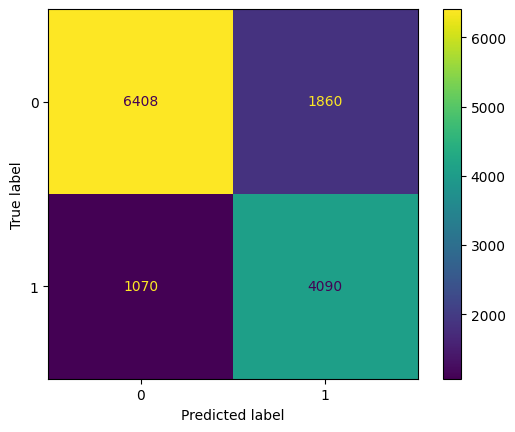

In [113]:
#Appalachia: confusion matrix
##for xbg optimized
cm_a = metrics.confusion_matrix(y_testA, yA_test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_a)
cm_display.plot()
plt.show()

In [114]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(xgboptimized_A, X_A, y_A, cv=10)
score
score.mean()

np.float64(0.781333695429079)

### Build Model: Non-Appalachia

In [115]:

##Repeat steps in nonAppalachia computation 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import train_test_split
X_trainNA, X_otherNA, y_trainNA, y_otherNA = train_test_split(X_NA, y_NA, test_size=0.30, random_state=42)
##splitting the 30 percent
X_testNA, X_valNA, y_testNA, y_valNA = train_test_split(X_otherNA, y_otherNA, test_size=0.33, random_state=42)

##logistic regression 
solvers = ['newton-cg', 'liblinear', 'lbfgs']
res= {}
for solver in solvers: 
    model = LogisticRegression(solver=solver, max_iter=1000, random_state=42)
    model.fit(X_trainNA, y_trainNA)
    y_valNA_pred = model.predict(X_valNA)
    print(f"solver: {solver}, validation accuracy: {accuracy_score(y_valNA, y_valNA_pred)}")
    res[f"{solver}"] = accuracy_score(y_valNA, y_valNA_pred)


solver: newton-cg, validation accuracy: 0.6768285033245515
solver: liblinear, validation accuracy: 0.6768285033245515
solver: lbfgs, validation accuracy: 0.6768285033245515


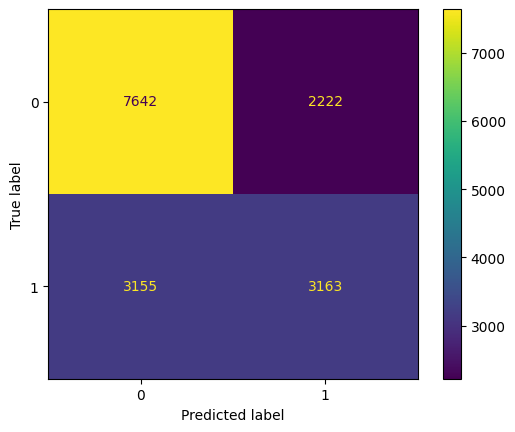

In [116]:
##cma for newton
#nonAppalachia: confusion matrix
from sklearn import metrics
import matplotlib.pyplot as plt
modelncg1 = LogisticRegression(solver='newton-cg', random_state=42)
modelncg1.fit(X_trainNA, y_trainNA)
y_testNA_pred = modelncg1.predict(X_testNA)
cm_a = metrics.confusion_matrix(y_testNA, y_testNA_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_a)
cm_display.plot()
plt.show()

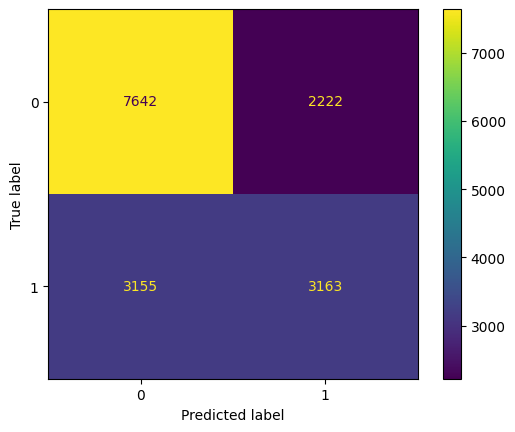

In [117]:
##cma for liblinear
#nonAppalachia: confusion matrix
from sklearn import metrics
import matplotlib.pyplot as plt
modellib1 = LogisticRegression(solver='liblinear', random_state=42)
modellib1.fit(X_trainNA, y_trainNA)
y_testNA_pred = modellib1.predict(X_testNA)
cm_a = metrics.confusion_matrix(y_testNA, y_testNA_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_a)
cm_display.plot()
plt.show()

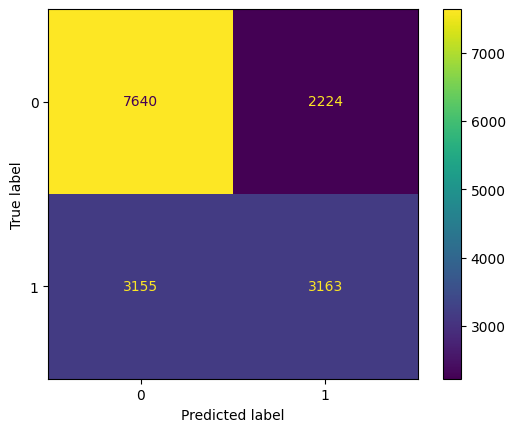

In [118]:
##cma for lbfgs
#nonAppalachia: confusion matrix
from sklearn import metrics
import matplotlib.pyplot as plt
model31 = LogisticRegression(solver='lbfgs', random_state=42)
model31.fit(X_trainNA, y_trainNA)
y_testNA_pred = model31.predict(X_testNA)
cm_a = metrics.confusion_matrix(y_testNA, y_testNA_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_a)
cm_display.plot()
plt.show()

In [119]:

##xgboost na
xgbc = XGBClassifier(random_state=42)
xgbc.fit(X_trainNA, y_trainNA)
y_valNA_pred_xgb = xgbc.predict(X_valNA)

accuracy_score(y_valNA, y_valNA_pred_xgb)


0.7884832517877305

In [38]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgbopt, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_trainNA,y_trainNA), 
                                   verbose=3, random_state=1001 )
# Here we go
random_search.fit(X_trainNA, y_trainNA)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 3/5] END colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=0.6, gamma=6.0, learning_rate=0.0001, max_depth=6, min_child_weight=10, n_estimators=500, reg_alpha=5.0, subsample=0.6;, score=0.864 total time=   1.3s
[CV 1/5] END colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=0.6, gamma=6.0, learning_rate=0.0001, max_depth=6, min_child_weight=10, n_estimators=500, reg_alpha=5.0, subsample=0.6;, score=0.870 total time=   1.3s
[CV 2/5] END colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=0.6, gamma=6.0, learning_rate=0.0001, max_depth=6, min_child_weight=10, n_estimators=500, reg_alpha=5.0, subsample=0.6;, score=0.863 total time=   1.3s
[CV 4/5] END colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=0.6, gamma=6.0, learning_rate=0.0001, max_depth=6, min_child_weight=10, n_estimators=500, reg_alpha=5.0, subsample=0.6;, score=0.865 total time=   1.3s
[CV 1/5] END colsample_bylevel=0

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x17b485e00>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=No...
                                        'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.0, 2.0, 4.0, 6.0, 8.0,
                                                  10.0],
                                        'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 0.2, 0.3],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12],
                                        'min_child_weight': [1, 3, 5, 7, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 800, 900,
                                                         1000],
                                        'reg_alpha': [0.0, 2.0, 5.0, 7.0, 10.0],
                                        'subsample': [0.4, 0.6, 0.8, 1.0]},
                   random_state=1001, scoring='roc_auc', verbose=3)

In [39]:
#optimize xgboost
xgboptimized_NA = xgb.XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=1.0, colsample_bynode=0.5, colsample_bytree=0.8,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=10.0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=7, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None)
xgboptimized_NA.fit(X_trainNA, y_trainNA)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=1.0, colsample_bynode=0.5, colsample_bytree=0.8,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=10.0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

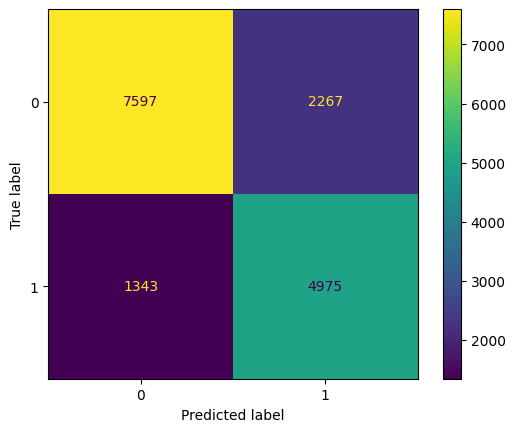

In [40]:
#nonAppalachia: confusion matrix
##for xgb
from sklearn import metrics
import matplotlib.pyplot as plt
y_testNA_pred = xgboptimized_NA.predict(X_testNA)
cm_a = metrics.confusion_matrix(y_testNA, y_testNA_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_a)
cm_display.plot()
plt.show()

### Calculate Bias between Appalachia and non-Applachia ML Models using Desparate Impact Ratio

In [41]:
##Step 1: Setup test dataframes for Appalachia/Non-Appalachia using data_A and data_NA. You can use train_test_split) to accomplish this step.
X_train_A_bias, X_test_A_bias, y_train_A_bias, y_test_A_bias = train_test_split(X_A, y_A, test_size=0.3, random_state=42)
X_train_NA_bias, X_test_NA_bias, y_train_NA_bias, y_test_NA_bias = train_test_split(X_NA, y_NA, test_size=0.3, random_state=42)

##Step 2: Insert predicted survival _recode into the test_A, test_NA dataframes
cls = xgb.XGBClassifier(random_state=42)
modela = cls.fit(X_train_A_bias, y_train_A_bias)
modelna = cls.fit(X_train_NA_bias, y_train_NA_bias)
y_testA_pred = modela.predict(X_test_A_bias)
y_testNA_pred = modelna.predict(X_test_NA_bias)

test_A = X_test_A_bias.copy()
test_A['y_prediction'] = y_testA_pred


test_NA = X_test_NA_bias.copy()
test_NA = pd.DataFrame(test_NA, columns=[f'feature_{i}' for i in range(test_NA.shape[1])])
test_NA['y_prediction'] = y_testNA_pred


#step3 count privileged and underpriviledged
counttesta = test_A[test_A['y_prediction'] == 1].shape[0]
counttestna = test_NA[test_NA['y_prediction'] == 1].shape[0]

#step 4: compute survived outcomes
survived_A = sum(test_A['y_prediction'] == 1)  # Count predictions = 1 for Appalachia
survived_NA = sum(test_NA['y_prediction'] == 1)  # Count predictions = 1 for Non-Appalachia

#step5 ratios
underprivileged_ratio = survived_NA / counttesta
privileged_ratio = survived_A / counttestna

bias = privileged_ratio / underprivileged_ratio

if bias != 1:
    print(f'the bias is {bias}')
else:
    print('there is no bias.')
    bias = None

print(f"Bias: {bias}")

the bias is 0.6946293074390191
Bias: 0.6946293074390191


### Plot AUROC for Appalachia, Non-Appalachia, and Baseline

In [42]:
#ROC Curve: Appalachia, non-appalachia, and baseline
#AUROC metrics for Appalachia = 
fpr_a, tpr_a, threshold_a, auc_a = generate_auc_roc_curve(xgboptimized_A, X_testA, y_testA)
fpr_na, tpr_na, threshold_na, auc_na = generate_auc_roc_curve(xgboptimized_NA, X_testNA, y_testNA)

#baseline
fpr_b = [0, 0.5, 1.]
tpr_b = [0, 0.5, 1.]

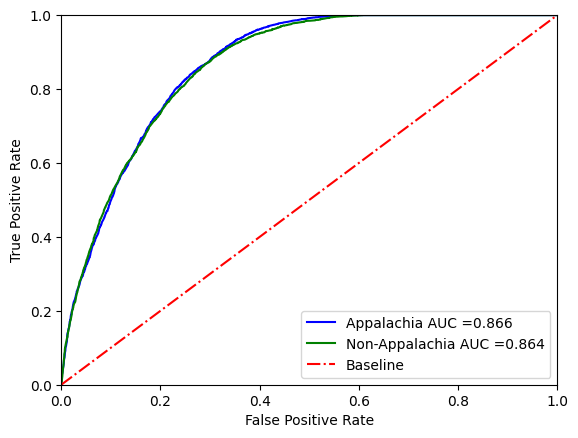

In [43]:
plt.plot(fpr_a, tpr_a, label="Appalachia AUC =" +str(auc_a), linewidth=1.5, color='b')
plt.plot(fpr_na, tpr_na, label="Non-Appalachia AUC =" +str(auc_na), linewidth=1.5, color='g')
plt.plot(fpr_b, tpr_b, label="Baseline", linestyle='dashdot', linewidth=1.5, color='r')
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

### Appalachia: AUROC scores by boostrap and replace samples

In [44]:
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
def bootstrap(model, X_test, y_true):
    rng = np.random.RandomState(42)
    b_scores = []
    y_pred = model.predict_proba(X_test)[:,1]
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
        score = roc_auc_score(y_true[indices], y_pred[indices])
        b_scores.append(score)
        #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    return b_scores

In [45]:
#get a list of booststrap scores

yA_true = y_testA
X_testA = X_testA.reset_index(drop=True)
yA_true = yA_true.reset_index(drop=True)
b_scores_a = bootstrap(xgboptimized_A, X_testA, yA_true)

In [46]:
#Mean of the histogram
import statistics as sm
mean_value_a = sm.mean(b_scores_a)
print ("Mean =", round(mean_value_a,3))

Mean = 0.866


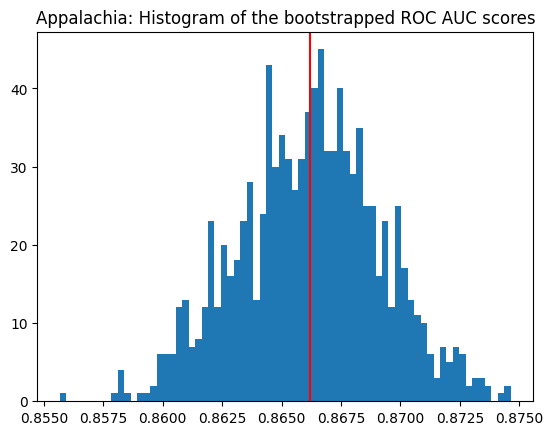

In [47]:
import matplotlib.pyplot as plt
plt.hist(b_scores_a, bins=70)
plt.title('Appalachia: Histogram of the bootstrapped ROC AUC scores')
#show the line on historgram for Median value
plt.axvline(x=mean_value_a, color='r')
plt.show()

In [48]:
#compute confidence interval for AUROC 
sorted_scores = np.array(b_scores_a)
sorted_scores.sort()

# Computing the lower and upper bound of the 95% confidence interval
ci_lower_auroc = sorted_scores[int(0.025 * len(sorted_scores))]
ci_upper_auroc = sorted_scores[int(0.975 * len(sorted_scores))]
print("Appalachia: Confidence interval for AUROC: [{:0.3f} - {:0.3}]".format(ci_lower_auroc, ci_upper_auroc))

Appalachia: Confidence interval for AUROC: [0.860 - 0.872]


### Non-Appalachia: AUROC scores by boostrap and replace samples

In [49]:
yNA_true = y_testNA
yNA_true = yNA_true.reset_index(drop=True)
b_scores_na = bootstrap(xgboptimized_NA, X_testNA, yNA_true)

#Mean of the histogram
import statistics as sm
mean_value_na = sm.mean(b_scores_na)
print ("Mean =", round(mean_value_na,3))

Mean = 0.864


In [50]:
#compute confidence interval for AUROC 
sorted_scores = np.array(b_scores_na)
sorted_scores.sort()

# Computing the lower and upper bound of the 95% confidence interval
ci_lower_auroc = sorted_scores[int(0.025 * len(sorted_scores))]
ci_upper_auroc = sorted_scores[int(0.975 * len(sorted_scores))]
print("Non-Appalachia: Confidence interval for AUROC: [{:0.3f} - {:0.3}]".format(ci_lower_auroc, ci_upper_auroc))

Non-Appalachia: Confidence interval for AUROC: [0.859 - 0.869]


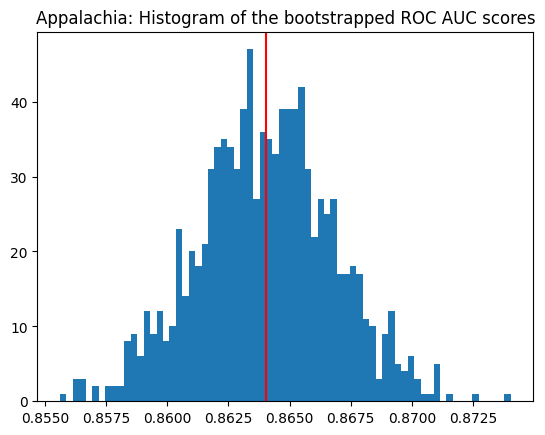

In [151]:
import matplotlib.pyplot as plt
plt.hist(b_scores_na, bins=70)
plt.title('Appalachia: Histogram of the bootstrapped ROC AUC scores')
#show the line on historgram for Median value
plt.axvline(x=mean_value_na, color='r')
plt.show()

### Appalachia: Metrics

In [51]:
#Appalachia: calculate metrics across the entire resampled data and report CI for all 4 metrics
n_iter=1000
tnr_a, tpr_a, ppv_a, npv_a = confmat(xgboptimized_A, X_testA, y_testA, n_iter)

In [ ]:
low, high = confmat_metrics(tpr_a)
print ("Bootstrap {}: Sensitivity(TPR):{} and the CI: [{} - {}]" .format(n_iter, round(np.mean(tpr_a),3), round(low,3), round(high,3)))
low, high = confmat_metrics(tnr_a)
print ("Bootstrap {}: Specificity(TNR):{} and the CI: [{} - {}]" .format(n_iter, round(np.mean(tnr_a),3), round(low,3), round(high,3)))
low, high = confmat_metrics(ppv_a)
print ("Bootstrap {}: Precision(PPV):{} and the CI: [{} - {}]" .format(n_iter, round(np.mean(ppv_a),3), round(low,3), round(high,3)))
low, high = confmat_metrics(npv_a)
print ("Bootstrap {}: NPV:{} and the CI: [{} - {}]" .format(n_iter, round(np.mean(npv_a),3), round(low,3), round(high,3)))

Bootstrap 1000: Sensitivity(TPR):0.775 and the CI: [0.747 - 0.802]
Bootstrap 1000: Specificity(TNR):0.788 and the CI: [0.771 - 0.804]
Bootstrap 1000: Precision(PPV):0.695 and the CI: [0.682 - 0.706]
Bootstrap 1000: NPV:0.849 and the CI: [0.835 - 0.861]


### Non-Appalachia: Metrics

In [ ]:
#Non-Appalachia: Calculate metrics across the entire resampled data and report CI for all 4 metrics
n_iter=1000
tnr_na, tpr_na, ppv_na, npv_na = confmat(xgboptimized_NA, X_testNA, y_testNA, n_iter)

In [ ]:
low, high = confmat_metrics(tpr_na)
print ("Bootstrap {}: Sensitivity(TPR):{} and the CI: [{} - {}]" .format(n_iter, round(np.mean(tpr_na),3), round(low,3), round(high,3)))
low, high = confmat_metrics(tnr_na)
print ("Bootstrap {}: Specificity(TNR):{} and the CI: [{} - {}]" .format(n_iter, round(np.mean(tnr_na),3), round(low,3), round(high,3)))
low, high = confmat_metrics(ppv_na)
print ("Bootstrap {}: Precision(PPV):{} and the CI: [{} - {}]" .format(n_iter, round(np.mean(ppv_na),3), round(low,3), round(high,3)))
low, high = confmat_metrics(npv_na)
print ("Bootstrap {}: NPV:{} and the CI: [{} - {}]" .format(n_iter, round(np.mean(npv_na),3), round(low,3), round(high,3)))

Bootstrap 1000: Sensitivity(TPR):0.956 and the CI: [0.949 - 0.963]
Bootstrap 1000: Specificity(TNR):0.949 and the CI: [0.942 - 0.955]
Bootstrap 1000: Precision(PPV):0.924 and the CI: [0.915 - 0.932]
Bootstrap 1000: NPV:0.971 and the CI: [0.967 - 0.975]


### P-value computation

In [ ]:
#Calculate t-score
from scipy.stats import t
def calculate_t_score(sample1, sample2):
    mean1 = np.mean(sample1)
    mean2 = np.mean(sample2)
    std1 = np.std(sample1, ddof=1) 
    std2 = np.std(sample2, ddof=1)
    n1 = len(sample1)
    n2 = len(sample2)
    t_score = (mean1 - mean2) / np.sqrt((std1**2 / n1) + (std2**2 / n2))
    return t_score

# Step 2: Determine the degrees of freedom (df)
def calculate_degrees_of_freedom(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    df = n1 + n2 - 2  # For a two-sample t-test
    return df

# Step 3: Identify the appropriate t-distribution
# (The scipy.stats.t distribution is used, which automatically considers the degrees of freedom)
 
# Step 4: Find the p-value
def calculate_p_value(t_score, df):
    p_value = 2 * (1 - t.cdf(np.abs(t_score), df))
    return p_value
 
# Step 5: Interpret the p-value
def interpret_p_value(p_value, alpha=0.05):
    if p_value < alpha:
        return "Reject the null hypothesis. There is a statistically significant difference."
    else:
        return "Fail to reject the null hypothesis. There is no statistically significant difference."

In [ ]:
# pick two samples:Appalachia and non-Appalachia
#ROC Scores
t_score = calculate_t_score(b_scores_a, b_scores_na)
df = calculate_degrees_of_freedom(b_scores_a, b_scores_na)
p_value = calculate_p_value(t_score, df)
result = interpret_p_value(p_value)
print("t_score:", t_score, "df:", df)
print("p-value:", p_value)
print(result)

t_score: 276.6805735540378 df: 1998
p-value: 0.0
Reject the null hypothesis. There is a statistically significant difference.


In [ ]:
# pick two samples:Appalachia and non-Appalachia
#TPR
t_score = calculate_t_score(tpr_a, tpr_na)
df = calculate_degrees_of_freedom(tpr_a, tpr_na)
p_value = calculate_p_value(t_score, df)
result = interpret_p_value(p_value)
print("t_score:", t_score, "df:", df)
print("p-value:", p_value)
print(result)


t_score: -393.01080951595117 df: 1998
p-value: 0.0
Reject the null hypothesis. There is a statistically significant difference.


In [ ]:
# pick two samples:Appalachia and non-Appalachia
#TNR
t_score = calculate_t_score(tnr_a, tnr_na)
df = calculate_degrees_of_freedom(tnr_a, tnr_na)
p_value = calculate_p_value(t_score, df)
result = interpret_p_value(p_value)
print("t_score:", t_score, "df:", df)
print("p-value:", p_value)
print(result)
##p-value: 0.013536729614925358

t_score: -569.343920843779 df: 1998
p-value: 0.0
Reject the null hypothesis. There is a statistically significant difference.


In [ ]:
# pick two samples:Appalachia and non-Appalachia
#PPV
t_score = calculate_t_score(ppv_a, ppv_na)
df = calculate_degrees_of_freedom(ppv_a, ppv_na)
p_value = calculate_p_value(t_score, df)
result = interpret_p_value(p_value)
print("t_score:", t_score, "df:", df)
print("p-value:", p_value)
print(result)

##p-value: 4.6230619332732203e-10

t_score: -955.9261018483132 df: 1998
p-value: 0.0
Reject the null hypothesis. There is a statistically significant difference.


In [ ]:
#NPV
t_score = calculate_t_score(npv_a, npv_na)
df = calculate_degrees_of_freedom(npv_a, npv_na)
p_value = calculate_p_value(t_score, df)
result = interpret_p_value(p_value)
print("t_score:", t_score, "df:", df)
print("p-value:", p_value)
print(result)

t_score: -548.5984798536977 df: 1998
p-value: 0.0
Reject the null hypothesis. There is a statistically significant difference.


## Model Validation: Appalachia

In [ ]:
#Appalachia : Calculate metrics across the entire resampled data and report CI for all 4 metrics
n_iter=1000
tnr_va, tpr_va, ppv_va, npv_va = confmat(xgboptimized_A, X_valA, y_valA, n_iter)

In [ ]:
low, high = confmat_metrics(tpr_va)
print ("Validation-A: Bootstrap {}: Sensitivity(TPR):{} and the CI: [{} - {}]" .format(n_iter, round(np.mean(tpr_va),3), round(low,3), round(high,3)))
low, high = confmat_metrics(tnr_va)
print ("Validation-A: Bootstrap {}: Specificity(TNR):{} and the CI: [{} - {}]" .format(n_iter, round(np.mean(tnr_va),3), round(low,3), round(high,3)))
low, high = confmat_metrics(ppv_va)
print ("Validation-A: Bootstrap {}: Precision(PPV):{} and the CI: [{} - {}]" .format(n_iter, round(np.mean(ppv_va),3), round(low,3), round(high,3)))
low, high = confmat_metrics(npv_va)
print ("Validation-A: Bootstrap {}: NPV:{} and the CI: [{} - {}]" .format(n_iter, round(np.mean(npv_va),3), round(low,3), round(high,3)))

Validation-A: Bootstrap 1000: Sensitivity(TPR):0.756 and the CI: [0.711 - 0.801]
Validation-A: Bootstrap 1000: Specificity(TNR):0.801 and the CI: [0.774 - 0.826]
Validation-A: Bootstrap 1000: Precision(PPV):0.695 and the CI: [0.677 - 0.714]
Validation-A: Bootstrap 1000: NPV:0.845 and the CI: [0.827 - 0.863]


#### Non-Appalachia

In [ ]:
#Non-Appalachia : Calculate metrics across the entire resampled data and report CI for all 4 metrics
n_iter=1000
tnr_vna, tpr_vna, ppv_vna, npv_vna = confmat(xgboptimized_NA, X_valNA, y_valNA, n_iter)

In [ ]:
low, high = confmat_metrics(tpr_vna)
print ("Validation-NA: Bootstrap {}: Sensitivity(TPR):{} and the CI: [{} - {}]" .format(n_iter, round(np.mean(tpr_vna),3), round(low,3), round(high,3)))
low, high = confmat_metrics(tnr_vna)
print ("Validation-NA: Bootstrap {}: Specificity(TNR):{} and the CI: [{} - {}]" .format(n_iter, round(np.mean(tnr_vna),3), round(low,3), round(high,3)))
low, high = confmat_metrics(ppv_vna)
print ("Validation-NA: Bootstrap {}: Precision(PPV):{} and the CI: [{} - {}]" .format(n_iter, round(np.mean(ppv_vna),3), round(low,3), round(high,3)))
low, high = confmat_metrics(npv_vna)
print ("Validation-NA: Bootstrap {}: NPV:{} and the CI: [{} - {}]" .format(n_iter, round(np.mean(npv_vna),3), round(low,3), round(high,3)))

Validation-NA: Bootstrap 1000: Sensitivity(TPR):0.988 and the CI: [0.984 - 0.992]
Validation-NA: Bootstrap 1000: Specificity(TNR):0.984 and the CI: [0.98 - 0.988]
Validation-NA: Bootstrap 1000: Precision(PPV):0.976 and the CI: [0.97 - 0.982]
Validation-NA: Bootstrap 1000: NPV:0.992 and the CI: [0.99 - 0.995]


## SHAP Plots

### Appalachia

In [ ]:
import shap
Xd = xgb.DMatrix(X_valA, label=y_valA)
model = xgb.train({"eta":0.3, "max_depth":10, "base_score":0.5, "lambda":0},Xd,1000)

In [ ]:
modelpredict = model.predict(Xd)
model_error = np.linalg.norm(y_valA - modelpredict)
print("Model error =", round(model_error,3))

Model error = 5.459


In [ ]:
#print(model.get_dump(with_stats=True)[0])

In [ ]:
explainer = shap.TreeExplainer(model)
explanation = explainer(Xd)
shap_values = explanation.values

In [ ]:
# make sure the SHAP values add up to marginal predictions. Should be Zero
print(round(np.abs(shap_values.sum(axis=1)
                  + explanation.base_values - np.array(y_valA)).max(),2))

0.68


In [ ]:
#print(explanation.data)
explanation.data = X_valA

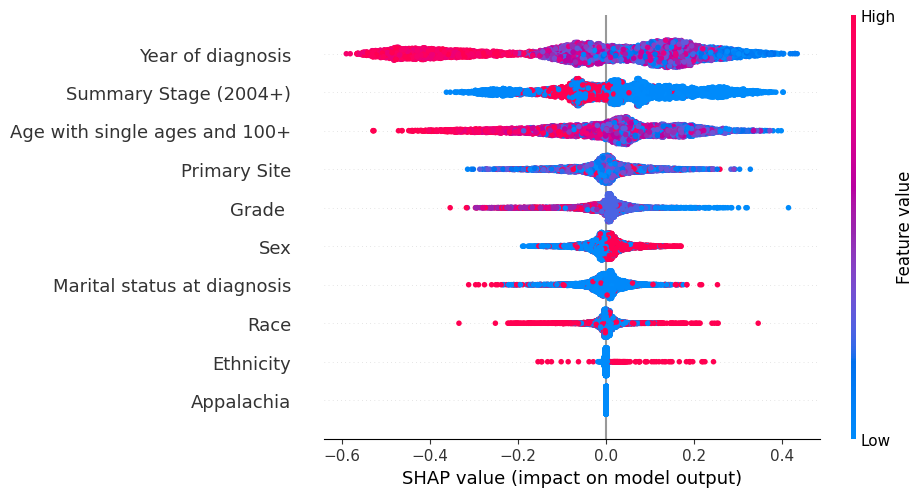

In [ ]:
shap.plots.beeswarm(explanation)

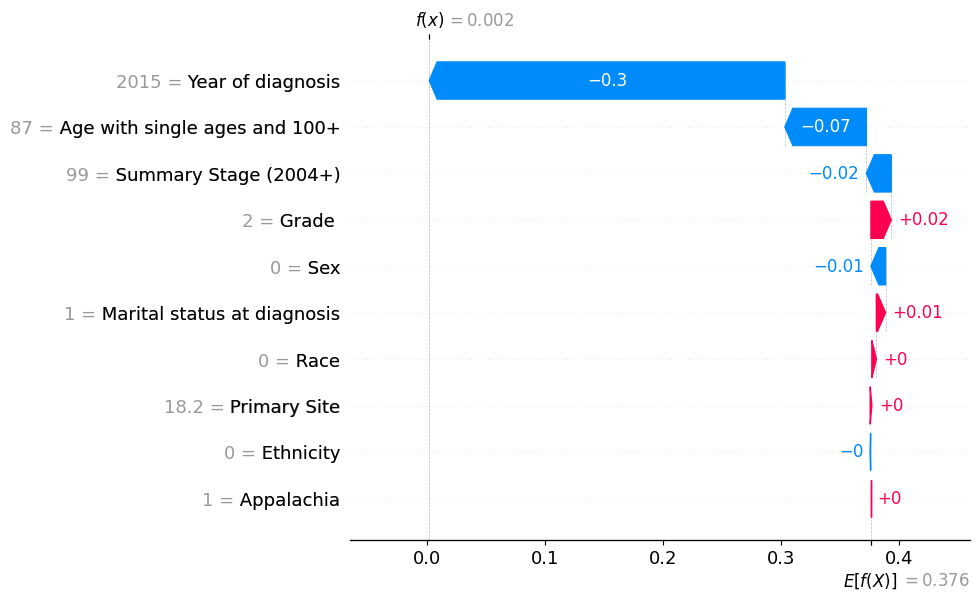

In [ ]:
shap.plots.waterfall(explanation[1])

## Non-Appalachia

In [588]:
#Assignment 
import shap
Xd = xgb.DMatrix(X_valNA, label=y_valNA)
model = xgb.train({"eta":0.3, "max_depth":10, "base_score":0.5, "lambda":0},Xd,1000)

In [591]:
modelpredict = model.predict(Xd)
model_error = np.linalg.norm(y_valNA - modelpredict)
print("Model error =", round(model_error,3))

Model error = 6.125


In [597]:
explainer = shap.TreeExplainer(model)
explanation = explainer(Xd)
shap_values = explanation.values

In [593]:
# make sure the SHAP values add up to marginal predictions. Should be Zero
print(round(np.abs(shap_values.sum(axis=1)
                  + explanation.base_values - np.array(y_valNA)).max(),2))

0.75


In [594]:
#print(explanation.data)
explanation.data = X_valNA

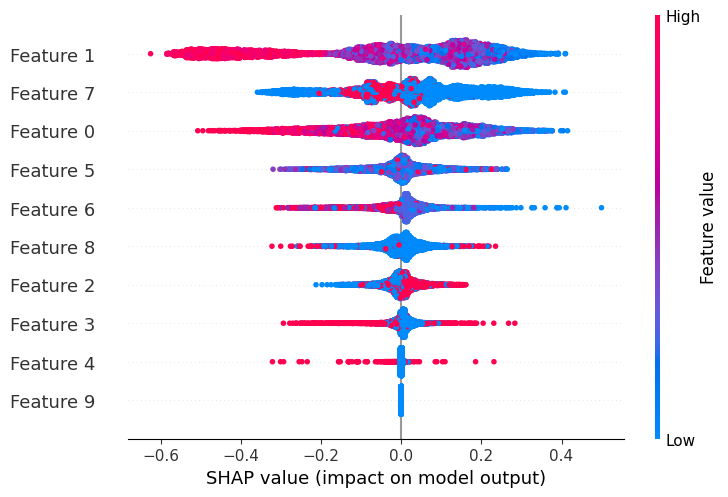

In [595]:
shap.plots.beeswarm(explanation)

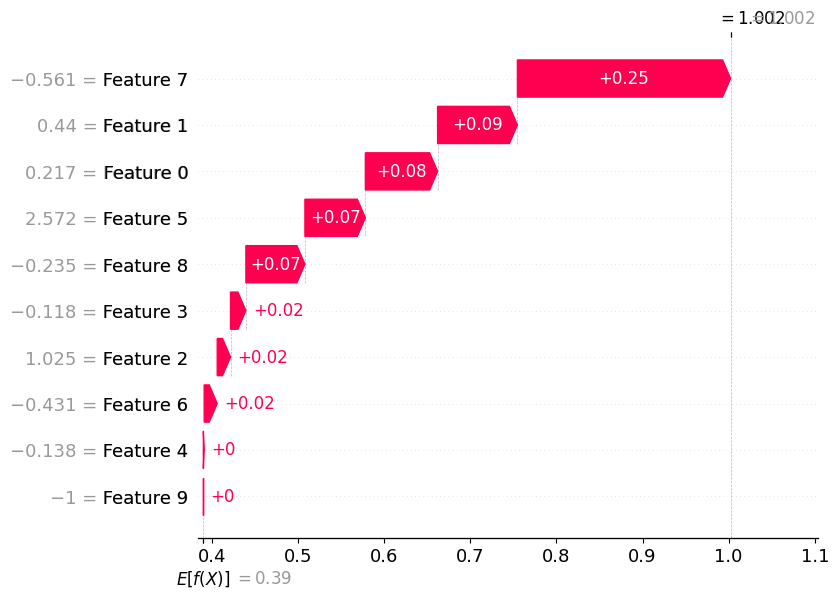

In [596]:
shap.plots.waterfall(explanation[1])

' Extra credit (3 pts). Build XGBoost optimized model with following changes to the dataset

Add radiotherapy and chemotherapy data into clinical features,
Drop Age from Demographics
and compare SHAP plots (1 pt.), Bias using Desperate Index (1 pt), and compare changes with XGBoost optimized model with dataset in II.'

In [133]:
##extra credit

dfec = df[['Age with single ages and 100+', 'Year of diagnosis', 'Sex','Race','Ethnicity','Primary Site','Grade ','Summary Stage (2004+)','Marital status at diagnosis', 'Radiation', 'Chemotherapy ', 'Appalachia','Survival recode'
]]

dfec = dfec.drop(columns={'Age with single ages and 100+'})

dfec = dfnew.rename(columns={
    'Survival recode': 'Survival_Recode'
})

dfec = dfec[dfec['Survival_Recode'] != 99]
##cleaning non-ordinal values and cleaning survival recode na
find_non_numeric = dfec.select_dtypes(include=['object']).columns
for col in find_non_numeric:
    dfec[col] = LabelEncoder().fit_transform(dfec[col].astype(str))


In [135]:
#Standardize and Scale the Feature Data:Appalachia
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

data_A1 = dfec[dfec['Appalachia'] == 1]
data_NA1 = dfec[dfec['Appalachia'] == 0]

ss_a=StandardScaler()
ss_a.fit_transform(data_A1.drop(['Survival_Recode'], axis=1))
scaled_data1=ss_a.transform(data_A1.drop(['Survival_Recode'], axis=1))
scaled_df1=pd.DataFrame(scaled_data1, columns=data_A1.columns[:-1])


X_A1 = scaled_df
y_A1=data_A1['Survival_Recode']

from sklearn.preprocessing import StandardScaler
ss_na=StandardScaler()
ss_na.fit_transform(data_NA1.drop(['Survival_Recode'], axis=1))
scaled_data_NA1 = ss_a.transform(data_NA1.drop(['Survival_Recode'], axis=1))
scaled_df_NA1= pd.DataFrame(scaled_data_NA1, columns=data_NA1.columns[:-1])

#setup X and y
#X_NA = scaled_df_NA.drop(['Survival_Recode'], axis=1)
X_NA1 = scaled_data_NA1
y_NA1=data_NA1['Survival_Recode']

In [136]:
from sklearn.model_selection import train_test_split
X_trainA1, X_otherA1, y_trainA1, y_otherA1 = train_test_split(X_A1, y_A1, test_size=0.30, random_state=42)
##splitting the 30 percent
X_testA1, X_valA1, y_testA1, y_valA1 = train_test_split(X_otherA1, y_otherA1, test_size=0.33, random_state=42)

In [137]:
##xgboost - default 
import xgboost as xgb
from xgboost import XGBClassifier
xgbc = XGBClassifier(random_state=42)
xgbc.fit(X_trainA1, y_trainA1, verbose=True)
y_valA_pred_xgb1 = xgbc.predict(X_valA1)

accuracy_score(y_valA1, y_valA_pred_xgb1)

0.7834895675839129

In [138]:
#xgboost optimized
opt_A1 = xgb.XGBClassifier()
opt_A1.fit(X_trainA1, y_trainA1)
y_test_pred_optA1 = opt_A1.predict(X_testA1) ##prediction survival record predicted value to calculate bias
xgbopt = xgb.XGBClassifier()


In [139]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgbopt, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_trainA1,y_trainA1), 
                                   verbose=3, random_state=1001 )
# Here we go
random_search.fit(X_trainA1, y_trainA1)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=0.6, gamma=6.0, learning_rate=0.0001, max_depth=6, min_child_weight=10, n_estimators=500, reg_alpha=5.0, subsample=0.6;, score=0.861 total time=   1.0s
[CV 3/5] END colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=0.6, gamma=6.0, learning_rate=0.0001, max_depth=6, min_child_weight=10, n_estimators=500, reg_alpha=5.0, subsample=0.6;, score=0.871 total time=   1.0s
[CV 4/5] END colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=0.6, gamma=6.0, learning_rate=0.0001, max_depth=6, min_child_weight=10, n_estimators=500, reg_alpha=5.0, subsample=0.6;, score=0.866 total time=   1.0s
[CV 2/5] END colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=0.6, gamma=6.0, learning_rate=0.0001, max_depth=6, min_child_weight=10, n_estimators=500, reg_alpha=5.0, subsample=0.6;, score=0.864 total time=   1.0s
[CV 2/5] END colsample_bylevel=0

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x17dcd3780>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=No...
                                        'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.0, 2.0, 4.0, 6.0, 8.0,
                                                  10.0],
                                        'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 0.2, 0.3],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12],
                                        'min_child_weight': [1, 3, 5, 7, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 800, 900,
                                                         1000],
                                        'reg_alpha': [0.0, 2.0, 5.0, 7.0, 10.0],
                                        'subsample': [0.4, 0.6, 0.8, 1.0]},
                   random_state=1001, scoring='roc_auc', verbose=3)

In [140]:
random_search.best_params_

{'subsample': 0.6,
 'reg_alpha': 10.0,
 'n_estimators': 100,
 'min_child_weight': 7,
 'max_depth': 3,
 'learning_rate': 0.3,
 'gamma': 10.0,
 'colsample_bytree': 0.8,
 'colsample_bynode': 0.5,
 'colsample_bylevel': 1.0}

In [143]:
xgboptimized_A = xgb.XGBClassifier(subsample= 0.6, reg_alpha= 10.0,
    n_estimators=100,
    min_child_weight=7,
    max_depth=5,
    learning_rate=0.3,
    gamma=10.0,
    colsample_bytree=0.8,
    colsample_bynode= 0.5,
    colsample_bylevel=1.0, random_state=42)

In [ ]:
xgboptimized_A.fit(X_trainA1, y_trainA1, verbose=True)
y_valA_pred_xgb1 = xgbc.predict(X_valA1)

accuracy_score(y_valA1, y_valA_pred_xgb1)

0.7834895675839129

In [146]:
##Repeat steps in nonAppalachia computation 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import train_test_split
X_trainNA1, X_otherNA1, y_trainNA1, y_otherNA1 = train_test_split(X_NA1, y_NA1, test_size=0.30, random_state=42)
##splitting the 30 percent
X_testNA1, X_valNA1, y_testNA1, y_valNA1 = train_test_split(X_otherNA1, y_otherNA1, test_size=0.33, random_state=42)


##xgboost na
xgbc = XGBClassifier(random_state=42)
xgbc.fit(X_trainNA1, y_trainNA1)
y_valNA_pred_xgb1 = xgbc.predict(X_valNA1)

accuracy_score(y_valNA1, y_valNA_pred_xgb1)

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgbopt, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_trainNA1,y_trainNA1), 
                                   verbose=3, random_state=1001 )
# Here we go
random_search.fit(X_trainNA1, y_trainNA1)



Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 2/5] END colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=0.6, gamma=6.0, learning_rate=0.0001, max_depth=6, min_child_weight=10, n_estimators=500, reg_alpha=5.0, subsample=0.6;, score=0.863 total time=   1.4s
[CV 4/5] END colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=0.6, gamma=6.0, learning_rate=0.0001, max_depth=6, min_child_weight=10, n_estimators=500, reg_alpha=5.0, subsample=0.6;, score=0.865 total time=   1.4s
[CV 3/5] END colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=0.6, gamma=6.0, learning_rate=0.0001, max_depth=6, min_child_weight=10, n_estimators=500, reg_alpha=5.0, subsample=0.6;, score=0.864 total time=   1.5s
[CV 1/5] END colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=0.6, gamma=6.0, learning_rate=0.0001, max_depth=6, min_child_weight=10, n_estimators=500, reg_alpha=5.0, subsample=0.6;, score=0.870 total time=   1.5s
[CV 1/5] END colsample_bylevel=0

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x17de08f20>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=No...
                                        'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.0, 2.0, 4.0, 6.0, 8.0,
                                                  10.0],
                                        'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 0.2, 0.3],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12],
                                        'min_child_weight': [1, 3, 5, 7, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 800, 900,
                                                         1000],
                                        'reg_alpha': [0.0, 2.0, 5.0, 7.0, 10.0],
                                        'subsample': [0.4, 0.6, 0.8, 1.0]},
                   random_state=1001, scoring='roc_auc', verbose=3)

In [147]:
random_search.best_params_

{'subsample': 0.6,
 'reg_alpha': 10.0,
 'n_estimators': 100,
 'min_child_weight': 7,
 'max_depth': 3,
 'learning_rate': 0.3,
 'gamma': 10.0,
 'colsample_bytree': 0.8,
 'colsample_bynode': 0.5,
 'colsample_bylevel': 1.0}

In [148]:
xgboptimized_NA1 = xgb.XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=1.0, colsample_bynode=0.5, colsample_bytree=0.8,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=10.0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=7, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None)
xgboptimized_NA1.fit(X_trainNA1, y_trainNA1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=1.0, colsample_bynode=0.5, colsample_bytree=0.8,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=10.0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [150]:
xgboptimized_NA1.fit(X_trainA1, y_trainA1, verbose=True)
y_valA_pred_xgb1 = xgbc.predict(X_valA1)

accuracy_score(y_valA1, y_valA_pred_xgb1)

0.8039008164499546

In [149]:
##Step 1: Setup test dataframes for Appalachia/Non-Appalachia using data_A and data_NA. You can use train_test_split) to accomplish this step.
X_train_A1_bias, X_test_A1_bias, y_train_A1_bias, y_test_A1_bias = train_test_split(X_A1, y_A1, test_size=0.3, random_state=42)
X_train_NA1_bias, X_test_NA1_bias, y_train_NA1_bias, y_test_NA1_bias = train_test_split(X_NA1, y_NA1, test_size=0.3, random_state=42)

##Step 2: Insert predicted survival _recode into the test_A, test_NA dataframes
cls = xgb.XGBClassifier(random_state=42)
modela = cls.fit(X_train_A1_bias, y_train_A1_bias)
modelna = cls.fit(X_train_NA1_bias, y_train_NA1_bias)
y_testA1_pred = modela.predict(X_test_A1_bias)
y_testNA1_pred = modelna.predict(X_test_NA1_bias)

test_A1 = X_test_A1_bias.copy()
test_A1['y_prediction'] = y_testA1_pred


test_NA1 = X_test_NA1_bias.copy()
test_NA1 = pd.DataFrame(test_NA1, columns=[f'feature_{i}' for i in range(test_NA1.shape[1])])
test_NA1['y_prediction'] = y_testNA1_pred


#step3 count privileged and underpriviledged
counttesta1 = test_A1[test_A1['y_prediction'] == 1].shape[0]
counttestna1 = test_NA1[test_NA1['y_prediction'] == 1].shape[0]

#step 4: compute survived outcomes
survived_A1 = sum(test_A1['y_prediction'] == 1)  # Count predictions = 1 for Appalachia
survived_NA1 = sum(test_NA1['y_prediction'] == 1)  # Count predictions = 1 for Non-Appalachia

#step5 ratios
underprivileged_ratio1 = survived_NA1 / counttesta1
privileged_ratio1 = survived_A1 / counttestna1

bias = privileged_ratio1 / underprivileged_ratio1

if bias != 1:
    print(f'the bias is {bias}')
else:
    print('there is no bias.')
    bias = None

print(f"Bias: {bias}")

the bias is 0.6946293074390191
Bias: 0.6946293074390191


'SHAP Plot'

In [624]:
import shap
Xd = xgb.DMatrix(X_valA1, label=y_valA1)
model = xgb.train({"eta":0.3, "max_depth":10, "base_score":0.5, "lambda":0},Xd,1000)

In [625]:
modelpredict = model.predict(Xd)
model_error = np.linalg.norm(y_valA1 - modelpredict)
print("Model error =", round(model_error,3))

Model error = 5.459


In [626]:
explainer = shap.TreeExplainer(model)
explanation = explainer(Xd)
shap_values = explanation.values

0.68


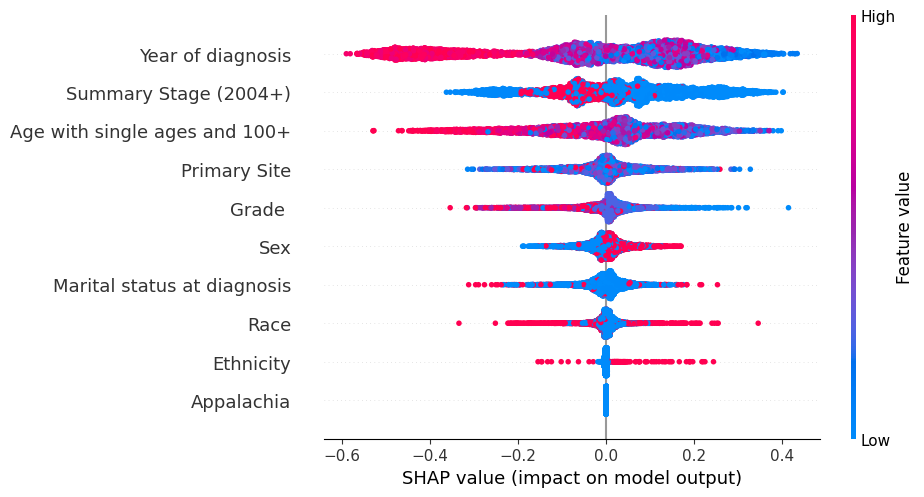

In [627]:
# make sure the SHAP values add up to marginal predictions. Should be Zero
print(round(np.abs(shap_values.sum(axis=1)
                  + explanation.base_values - np.array(y_valA1)).max(),2))
explanation.data = X_valA1
shap.plots.beeswarm(explanation)

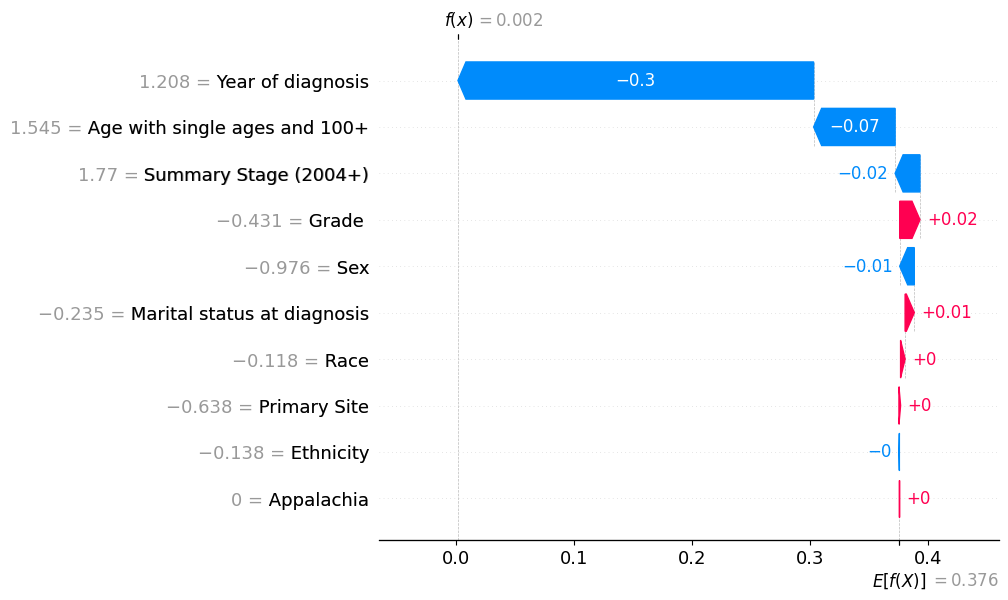

In [628]:
shap.plots.waterfall(explanation[1])

###
Non appalachia



In [632]:
#Assignment 
import shap
Xd = xgb.DMatrix(X_valNA1, label=y_valNA1)
model = xgb.train({"eta":0.3, "max_depth":10, "base_score":0.5, "lambda":0},Xd,1000)

In [633]:
modelpredict = model.predict(Xd)
model_error = np.linalg.norm(y_valNA1 - modelpredict)
print("Model error =", round(model_error,3))

Model error = 6.125


In [631]:
explainer = shap.TreeExplainer(model)
explanation = explainer(Xd)
shap_values = explanation.values

In [634]:
# make sure the SHAP values add up to marginal predictions. Should be Zero
print(round(np.abs(shap_values.sum(axis=1)
                  + explanation.base_values - np.array(y_valNA1)).max(),2))

0.75


In [635]:
#print(explanation.data)
explanation.data = X_valNA1

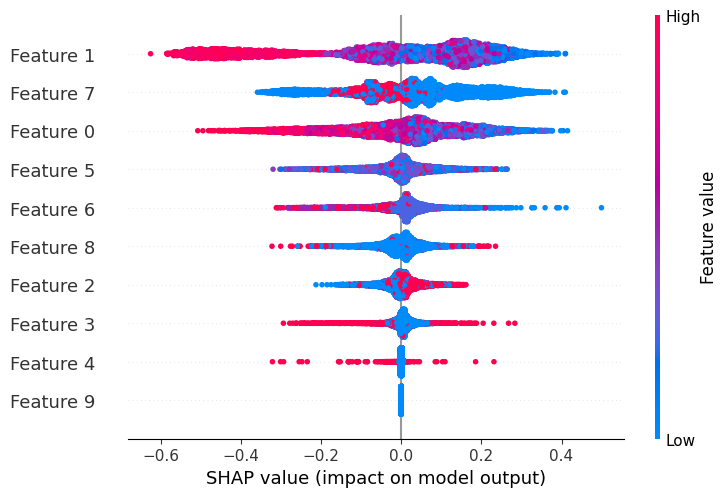

In [636]:
shap.plots.beeswarm(explanation)

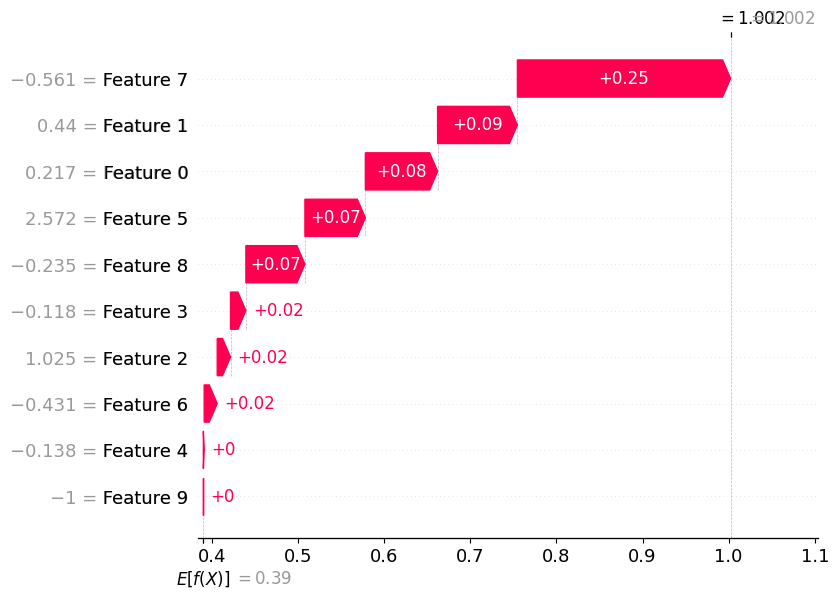

In [637]:
shap.plots.waterfall(explanation[1])